This note is used for updating cell calling in Tony's perturb pipeline 

In [46]:
import pandas as pd
import sys
from IPython.display import display
pd.set_option('display.max_colwidth', None)
print(sys.executable)

import argparse
import subprocess
import sys
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
import scanpy as sc
import os
from types import SimpleNamespace 
import scipy.sparse as sp


/oak/stanford/groups/engreitz/Users/shshanhe/tools/miniforge3/envs/torch-cNMF/bin/python


In [2]:
!which python
!which Rscript
!Rscript --version

/oak/stanford/groups/engreitz/Users/shshanhe/tools/miniforge3/envs/torch-cNMF/bin/python
which: no Rscript in (/oak/stanford/groups/engreitz/Users/shshanhe/tools/miniforge3/envs/torch-cNMF/bin:/home/users/shshanhe/miniconda3/condabin:/share/software/user/open/code-server/4.93.1/lib/node_modules/code-server/lib/vscode/bin/remote-cli:/share/software/user/srcc/bin:/share/software/user/open/nodejs/25.3.0/bin:/share/software/user/open/gcc/14.2.0/bin:/share/software/user/open/code-server/4.93.1/bin:/share/software/user/open/git/2.45.1/bin:/share/software/user/open/expat/2.2.3/bin:/share/software/user/open/curl/8.4.0/bin:/share/software/user/open/openssl/3.0.7/bin:/share/software/user/srcc/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/users/shshanhe/.local/bin:/home/users/shshanhe/bin:/home/users/shshanhe/.local/bin:/home/users/shshanhe/bin)


/bin/bash: Rscript: command not found


# unfilter adata

In [65]:
RESULT_PATH = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX60C_UMI_10/"
ADATA_PATH = RESULT_PATH+"adata_unfiltered_annotated.h5ad"
#RESULT_PATH+"/eRZ58:eRZ58_GEX60C.cellcalling.h5ad"
adata = sc.read_h5ad(ADATA_PATH)
adata
# obs = adata.obs.copy()
# obs
# obs.to_csv(RESULT_PATH+"cell_calling_summary_h5ad.tsv", index=False)


AnnData object with n_obs × n_vars = 27775 × 34183
    obs: 'guides_per_cell', 'guide_umi_counts', 'pct_counts_ribo', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pool', 'sample_id', 'round1', 'well', 'biological_sample', 'Rep', 'plate'
    var: 'gene_type', 'gene', 'chromosome', 'ribosomal', 'cell_cycle', 'cell_cycle_phase', 'pct_cells_expressed', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'guide_names'
    obsm: 'guide_assignment', 'guide_counts'
    layers: 'ambiguous', 'mature', 'nascent'

# load function

In [68]:

def load_h5ad_matrix(h5ad_file):
    """Load count matrix from kallisto h5ad output."""
    adata = sc.read_h5ad(h5ad_file)
    
    # Delete guide data from obsm to save memory (not needed for cell calling)
    if 'guide_counts' in adata.obsm:
        print(f"Removing guide_counts matrix from memory ({adata.obsm['guide_counts'].shape})")
        del adata.obsm['guide_counts']
    if 'guide_assignment' in adata.obsm:
        print(f"Removing guide_assignment matrix from memory")
        del adata.obsm['guide_assignment']
    
    # Sum layers to guarantee X is total counts
    adata.X = adata.layers['mature'] + adata.layers['nascent'] + adata.layers['ambiguous']
    
    # Calculate basic QC metrics if not already present
    if 'total_counts' not in adata.obs.columns:
        adata.var['mt'] = adata.var_names.str.match('(?i)^mt-') # ignore capital letter for both human and mouse
        #adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    return adata

def run_dropletutils_r(kb_dir, sample_id, output_dir, emptydrops_lower=100, ncores=1, expected_cells=0, 
                      run_emptydrops=False, run_barcoderanks=False, fdr_cutoffs=None, run_by_group=False):
    """Run R script for DropletUtils analysis (EmptyDrops and/or BarcodeRanks).
    
    NOTE: EmptyDrops is DEPRECATED. Use BarcodeRanks methods instead.
    EmptyDrops code is preserved for backwards compatibility but is not actively maintained.
    """
    # Get the path to the R script relative to this Python script
    # script_dir = os.path.dirname(os.path.abspath(__file__))
    # r_script_path = os.path.join(script_dir, "dropletutils_r.R")
    conda_bin="/home/users/shshanhe/miniconda3/condabin/conda"
    kb_prefix="/home/groups/engreitz/Users/tony/anaconda3/envs/kb"
    r_script_path="/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/scripts/dropletutils_r_per_biosample.R"
    rscript_bin = "/home/groups/engreitz/Users/tony/anaconda3/envs/kb/bin/Rscript"
    cmd = [
        conda_bin, "run",
        "-p", kb_prefix,
        "--no-capture-output", 
        "Rscript", "--vanilla", r_script_path,
        "--kb_dir", str(kb_dir),
        "--sample_id", str(sample_id),
        "--output_dir", str(output_dir),
        "--emptydrops_lower", str(emptydrops_lower),
        "--ncores", str(ncores),
        "--expected_cells", str(expected_cells)
     ]

    # cmd = [
    #     "Rscript", "--vanilla", r_script_path,  # Use --vanilla to ensure only conda R packages are used
    #     "--kb_dir", str(kb_dir),
    #     "--sample_id", sample_id,
    #     "--output_dir", str(output_dir),
    #     "--emptydrops_lower", str(emptydrops_lower),
    #     "--ncores", str(ncores),
    #     "--expected_cells", str(expected_cells)
    # ]
    
    if run_emptydrops:
        cmd.append("--run_emptydrops")
        if fdr_cutoffs:
            # Pass FDR cutoffs as comma-separated string
            cmd.extend(["--fdr_cutoffs", ",".join(map(str, fdr_cutoffs))])
    if run_barcoderanks:
        cmd.append("--run_barcoderanks")
    if run_by_group:
        cmd.append("--run_by_group")
    
    result = subprocess.run(cmd, check=True)
    print(f"DropletUtils R script completed successfully")

def expected_cell_method(adata, expected_cells):
    """Cell calling using expected cell count - take top N barcodes."""
    if 'total_counts' in adata.obs.columns:
        total_counts = adata.obs['total_counts'].values
    else:
        total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    sorted_indices = np.argsort(total_counts)[::-1]
    
    # Take top N barcodes
    n_cells = min(expected_cells, len(sorted_indices))
    cell_indices = sorted_indices[:n_cells]
    
    # Create boolean mask
    is_cell = np.zeros(adata.n_obs, dtype=bool)
    is_cell[cell_indices] = True
    
    return is_cell, total_counts[sorted_indices[n_cells-1]] if n_cells > 0 else 0

def threshold_method(adata, min_umi_threshold):
    """Cell calling using simple UMI threshold."""
    if 'total_counts' in adata.obs.columns:
        total_counts = adata.obs['total_counts'].values
    else:
        total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    is_cell = total_counts >= min_umi_threshold
    return is_cell, min_umi_threshold

def load_dropletutils_results(output_dir, sample_id, adata):
    """Load DropletUtils results from R script output (EmptyDrops + barcodeRanks)."""
    # Load DropletUtils results
    results_file = Path(output_dir) / "dropletutils_results.tsv"
    df = pd.read_csv(results_file, sep='\t')
    
    # Map back to adata
    barcode_to_idx = {bc: i for i, bc in enumerate(adata.obs_names)}
    
    # Load results for all methods
    results = {}
    
    # 1. Load EmptyDrops results from summary file to get actual FDR thresholds tested
    summary_file = Path(output_dir) / "cell_calling_summary.tsv"
    if summary_file.exists():
        summary_df = pd.read_csv(summary_file, sep='\t')
        
        # Process EmptyDrops results for each FDR threshold
        emptydrops_rows = summary_df[summary_df['method'].str.startswith('EmptyDrops_FDR')]
        for _, row in emptydrops_rows.iterrows():
            method_name = row['method']
            fdr_threshold = row['fdr_threshold']
            
            is_cell = np.zeros(adata.n_obs, dtype=bool)
            
            # Get cells below FDR threshold
            cells_df = df[df['fdr'] <= fdr_threshold]
            for barcode in cells_df['barcode']:
                if barcode in barcode_to_idx:
                    is_cell[barcode_to_idx[barcode]] = True
            
            results[method_name] = (is_cell, fdr_threshold)
    
    # 2. BarcodeRanks knee and inflection points
    # The R script saves a summary file with these values
    summary_file = Path(output_dir) / "cell_calling_summary.tsv"
    if summary_file.exists():
        summary_df = pd.read_csv(summary_file, sep='\t')
        
        # Get knee and inflection thresholds
        knee_row = summary_df[summary_df['method'] == 'BarcodeRanks_Knee']
        inflection_row = summary_df[summary_df['method'] == 'BarcodeRanks_Inflection']
        
        if not knee_row.empty:
            knee_threshold = knee_row.iloc[0]['threshold_used']
            # Get cells above knee threshold
            if 'total_counts' in adata.obs.columns:
                total_counts = adata.obs['total_counts'].values
            else:
                total_counts = np.array(adata.X.sum(axis=1)).flatten()
            
            is_cell_knee = total_counts >= knee_threshold
            results['BarcodeRanks_Knee'] = (is_cell_knee, knee_threshold)
        
        if not inflection_row.empty:
            inflection_threshold = inflection_row.iloc[0]['threshold_used']
            # Get cells above inflection threshold
            if 'total_counts' in adata.obs.columns:
                total_counts = adata.obs['total_counts'].values
            else:
                total_counts = np.array(adata.X.sum(axis=1)).flatten()
            
            is_cell_inflection = total_counts >= inflection_threshold
            results['BarcodeRanks_Inflection'] = (is_cell_inflection, inflection_threshold)
    
    return results

def load_dropletutils_results_by_group(output_dir, sample_id, adata):
    """
    Load per-group BarcodeRanks results produced by R script.

    Expected files:
      - dropletutils_results_by_group.tsv
      - cell_calling_summary_by_group.tsv (optional but nice for thresholds)

    Returns:
      methods_by_group: defaultdict(dict)
    """
    output_dir = Path(output_dir)
    by_group_file = output_dir / "dropletutils_results_by_group.tsv"
    if not by_group_file.exists():
        return defaultdict(dict)  # nothing

    df = pd.read_csv(by_group_file, sep="\t")

    # map barcode to global index in adata
    barcode_to_idx = {bc: i for i, bc in enumerate(adata.obs_names)}

    methods_by_group = defaultdict(dict)

    # Use per-row threshold columns (knee_threshold / inflection_threshold) if present
    # (they are repeated per row in that group; we'll take the first non-null)
    for g, gdf in df.groupby("group", sort=False):
        # global masks
        mask_knee = np.zeros(adata.n_obs, dtype=bool)
        mask_inf  = np.zeros(adata.n_obs, dtype=bool)

        # thresholds
        knee_thr = None
        inf_thr  = None

        if "knee_threshold" in gdf.columns:
            vals = gdf["knee_threshold"].dropna().unique()
            knee_thr = float(vals[0]) if len(vals) else np.nan
        else:
            knee_thr = np.nan

        if "inflection_threshold" in gdf.columns:
            vals = gdf["inflection_threshold"].dropna().unique()
            inf_thr = float(vals[0]) if len(vals) else np.nan
        else:
            inf_thr = np.nan

        # fill masks by barcode
        # guard: columns names in TSV
        has_knee_col = "is_cell_knee" in gdf.columns
        has_inf_col  = "is_cell_inflection" in gdf.columns
        if not (has_knee_col and has_inf_col):
            # If missing, we can't reconstruct masks reliably
            # Return empty for this group
            continue

        for _, row in gdf.iterrows():
            bc = row["barcode"]
            idx = barcode_to_idx.get(bc, None)
            if idx is None:
                continue
            if bool(row["is_cell_knee"]):
                mask_knee[idx] = True
            if bool(row["is_cell_inflection"]):
                mask_inf[idx] = True

        methods_by_group[g]["BarcodeRanks_Knee"] = (mask_knee, knee_thr)
        methods_by_group[g]["BarcodeRanks_Inflection"] = (mask_inf, inf_thr)

    return methods_by_group

def calculate_umis_in_cells_pct(adata, methods_results):
    """Calculate percentage of total UMIs that fall in called cells."""
    if 'total_counts' in adata.obs.columns:
        total_counts = adata.obs['total_counts'].values
    else:
        total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    total_umis = np.sum(total_counts)
    
    percentages = {}
    for method, (is_cell, threshold) in methods_results.items():
        umis_in_cells = np.sum(total_counts[is_cell])
        percentages[method] = (umis_in_cells / total_umis * 100) if total_umis > 0 else 0.0
    
    return percentages

def calculate_umis_in_cells_pct_by_group(adata, methods_by_group, group_col):
    if "total_counts" in adata.obs.columns:
        total_counts = adata.obs["total_counts"].to_numpy()
    else:
        total_counts = np.array(adata.X.sum(axis=1)).flatten()

    out = defaultdict(dict)

    for g, mdict in methods_by_group.items():
        g_mask = (adata.obs[group_col].values == g)         # global mask
        total_umis_g = float(total_counts[g_mask].sum())

        for method, (is_cell_global, _thr) in mdict.items():
            is_cell_global = np.asarray(is_cell_global, dtype=bool)  # global length
            umis_in_cells_g = float(total_counts[g_mask & is_cell_global].sum())
            out[g][method] = (umis_in_cells_g / total_umis_g * 100.0) if total_umis_g > 0 else 0.0

    return out
    
def get_cell_calling_params(config, sample_id):
    """Get cell calling parameters for a specific sample."""
    
    # Load sample-specific parameters from sample_info file (REQUIRED)
    sample_info_file = config['sample_info_file']
    if not os.path.exists(sample_info_file):
        raise FileNotFoundError(f"Sample info file not found: {sample_info_file}")
    
    sample_df = pd.read_excel(sample_info_file)
    
    sample_row = sample_df[sample_df['sample_id'] == sample_id]
    if sample_row.empty:
        raise ValueError(f"Sample {sample_id} not found in {sample_info_file}")
    
    row = sample_row.iloc[0]
    
    # REQUIRED: expected_cells must be specified
    if 'expected_cells' not in sample_df.columns or pd.isna(row['expected_cells']):
        raise ValueError(f"Expected cells must be specified for sample {sample_id} in {sample_info_file}")
    
    params = {'expected_cells': int(row['expected_cells'])}
    
    # Optional parameters with config defaults
    defaults = config['cell_calling']['defaults']
    if pd.notna(row.get('min_umi_threshold')):
        params['min_umi_threshold'] = int(row['min_umi_threshold'])
    else:
        params['min_umi_threshold'] = defaults.get('min_umi_threshold', 100)
    
    params['emptydrops_lower'] = defaults.get('emptydrops_lower', 100)

    # add cell calling by self-defined group info
    groupby_col = defaults.get('cell_calling_groupby_col')
    if groupby_col is not None:
        params['cell_calling_groupby_col'] = groupby_col
        params['expected_cells_per_biosample'] = defaults.get('expected_cells_per_biosample', 100)
        params['min_umi_threshold_per_biosample'] = defaults.get('min_umi_threshold_per_biosample', 100)
    else:
        params['cell_calling_groupby_col'] = None
    return params

# test main code

In [66]:
args = SimpleNamespace(
    #h5ad_file = "/scratch/users/shshanhe/eRZ58_20A_analysis/eRZ58:eRZ58_GEX20A/kb_all_main_raw/counts_filtered/adata.h5ad",
    h5ad_file = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1/adata_unfiltered_annotated.h5ad",
    kb_dir    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/", # dir还是json？ smk rule里用的是info json
    sample_id = "eRZ58:eRZ58_GEX20A",  # 确保这里的 ID 能在 Excel 表里找到
    config    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/config.eRZ59.yaml",
    output_dir= "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1", # 指定一个测试用的输出目录
    ncores    = 4
)

# args = SimpleNamespace(
#     # h5ad_file = "/scratch/users/shshanhe/eRZ58_40B_analysis/eRZ58:eRZ58_GEX40B/kb_all_main_raw/counts_filtered/adata.h5ad",
#     h5ad_file = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX40B_unfilered/adata_unfiltered_annotated.h5ad",
#     kb_dir    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/", # dir还是json？ smk rule里用的是info json   
#     # kb_dir    = "/scratch/users/shshanhe/eRZ58_40B_analysis/eRZ58:eRZ58_GEX40B/kb_all_main_raw/", # dir还是json？ smk rule里用的是info json
#     sample_id = "eRZ58:eRZ58_GEX40B",  # 确保这里的 ID 能在 Excel 表里找到
#     config    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/config.eRZ59.yaml",
#     output_dir= "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX40B_unfilered", # 指定一个测试用的输出目录
#     ncores    = 4
# )

# args = SimpleNamespace(
#     # h5ad_file = "/scratch/users/shshanhe/eRZ58_40B_analysis/eRZ58:eRZ58_GEX40B/kb_all_main_raw/counts_filtered/adata.h5ad",
#     h5ad_file = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX60C_unfilered/adata_unfiltered_annotated.h5ad",
#     kb_dir    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/", # dir还是json？ smk rule里用的是info json   
#     # kb_dir    = "/scratch/users/shshanhe/eRZ58_40B_analysis/eRZ58:eRZ58_GEX40B/kb_all_main_raw/", # dir还是json？ smk rule里用的是info json
#     sample_id = "eRZ58:eRZ58_GEX60C",  # 确保这里的 ID 能在 Excel 表里找到
#     config    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/config.eRZ59.yaml",
#     output_dir= "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX60C_unfilered", # 指定一个测试用的输出目录
#     ncores    = 4
# )
# args = SimpleNamespace(
#     h5ad_file = "/scratch/users/shshanhe/eRZ58_60C_analysis/eRZ58:eRZ58_GEX60C/kb_all_main_raw/counts_filtered/adata.h5ad",
#     kb_dir    = "/scratch/users/shshanhe/eRZ58_60C_analysis/eRZ58:eRZ58_GEX60C/kb_all_main_raw/", # dir还是json？ smk rule里用的是info json
#     sample_id = "eRZ58:eRZ58_GEX60C",  # 确保这里的 ID 能在 Excel 表里找到
#     config    = "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/config.eRZ59.yaml",
#     output_dir= "/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX60C", # 指定一个测试用的输出目录
#     ncores    = 4
# )


In [70]:

from collections import defaultdict

with open(args.config) as f:
    config = yaml.safe_load(f)

output_dir = Path(args.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"📂 output dir: {output_dir}")

print(f"🔧 Testing with sample: {args.sample_id}")
print(f"📂 Reading h5ad from: {args.h5ad_file}")

params = get_cell_calling_params(config, args.sample_id)

# 1. Load Data
print(f"📥 Loading data...")
adata = load_h5ad_matrix(args.h5ad_file)
print(f"Loaded matrix: {adata.n_obs} barcodes x {adata.n_vars} genes")
# Apply different cell calling methods
methods_results = {}
methods_results_by_biosample = defaultdict(dict)  # group -> {method: (is_cell, threshold)}

# Get list of methods to run from config
methods_to_run = config['cell_calling']['methods_to_run']
print(f"Running cell calling methods: {methods_to_run}")

# check if adata actually contains target groupby col
group_col = params['cell_calling_groupby_col']
if group_col is not None and group_col not in adata.obs.columns:
    print(f"[WARN] groupby col '{group_col}' not in adata.obs; fallback to per-sample calling.")
    group_col = None
# write barcode with group 
if group_col is not None:
    # filtering barcode with NA in group_col
    group_values = adata.obs[group_col].copy()
    valid_mask = group_values.notna() & (group_values.astype(str) != "nan") & (group_values.astype(str) != "")
    groups = sorted(group_values[valid_mask].unique().tolist())
    print(f"cell calling by group enabled: {group_col}, n_groups={len(groups)}")
    # write barcode with corresponding sample for cell calling
    metadata = adata.obs.loc[valid_mask, [group_col]].copy()
    metadata.insert(0, "barcode", metadata.index)  # ensure barcode column exists
    metadata = metadata.rename(columns={group_col: "cell_calling_by_group"})
    metadata = metadata[["barcode", "cell_calling_by_group"]]
    counts_dir = Path(args.kb_dir) / "dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1"
    #counts_dir = Path(args.kb_dir) / "counts_filtered"
    out_csv = counts_dir / "barcode_with_group.csv"
    metadata.to_csv(out_csv, index=False)


# Method 1: Expected cell count

if 'Expected_Cells' in methods_to_run:
    print(f"Running expected cell method (n={params['expected_cells']})...")
    methods_results['Expected_Cells'] = expected_cell_method(adata, params['expected_cells'])

    if group_col is not None:
        for g in groups:
            g_mask = (adata.obs[group_col].values == g)   # global bool mask, len = adata.n_obs
            adata_g = adata[g_mask]                       # local view

            local_mask, thr = expected_cell_method(adata_g, params['expected_cells_per_biosample'])
            global_mask = np.zeros(adata.n_obs, dtype=bool)
            global_mask[g_mask] = local_mask

            methods_results_by_biosample[g]["Expected_Cells"] = (global_mask, thr)

# Method 2: Threshold method
if 'UMI_Threshold' in methods_to_run:
    print(f"Running UMI threshold method (min_umi={params['min_umi_threshold']})...")
    methods_results['UMI_Threshold'] = threshold_method(adata, params['min_umi_threshold'])

    if group_col is not None:
        for g in groups:
            g_mask = (adata.obs[group_col].values == g)   # global bool mask, len = adata.n_obs
            adata_g = adata[g_mask]                       # local view

            local_mask, thr = threshold_method(adata_g, params["min_umi_threshold_per_biosample"])
            global_mask = np.zeros(adata.n_obs, dtype=bool)
            global_mask[g_mask] = local_mask
            
            methods_results_by_biosample[g]['UMI_Threshold'] = (global_mask, thr)


run_by_group = (group_col is not None)
# Method 3-7: DropletUtils methods (via R)
# Parse EmptyDrops methods and their FDR cutoffs
emptydrops_fdr_cutoffs = []
for method in methods_to_run:
    if method.startswith('EmptyDrops_FDR_'):
        # Parse FDR value from method name (e.g., EmptyDrops_FDR_0.001 -> 0.001)
        fdr_str = method.replace('EmptyDrops_FDR_', '')
        fdr_value = float(fdr_str)
        emptydrops_fdr_cutoffs.append(fdr_value)

barcoderanks_methods = ['BarcodeRanks_Knee', 'BarcodeRanks_Inflection']

run_emptydrops = len(emptydrops_fdr_cutoffs) > 0
run_barcoderanks = any(method in methods_to_run for method in barcoderanks_methods)

if run_emptydrops or run_barcoderanks:
    print("Running DropletUtils analysis on pre-filtered matrix...")
    if run_emptydrops:
        print(f"  - EmptyDrops enabled with FDR cutoffs: {emptydrops_fdr_cutoffs}")
        print("  WARNING: EmptyDrops is DEPRECATED. Use BarcodeRanks methods instead.")
    if run_barcoderanks:
        print("  - BarcodeRanks enabled")

    run_dropletutils_r(args.kb_dir, args.sample_id, output_dir, 
                        params['emptydrops_lower'], 
                        args.ncores,
                        params['expected_cells'],
                        run_emptydrops=run_emptydrops,
                        run_barcoderanks=run_barcoderanks,
                        fdr_cutoffs=emptydrops_fdr_cutoffs if run_emptydrops else None,
                        run_by_group=run_by_group 
                        )
    
    dropletutils_results = load_dropletutils_results(output_dir, args.sample_id, adata)

    # Only include methods that were requested
    for method in methods_to_run:
        if method in dropletutils_results:
            methods_results[method] = dropletutils_results[method]

    if run_by_group:
        dropletutils_results_by_group = load_dropletutils_results_by_group(output_dir, args.sample_id, adata)
        for g, mdict in dropletutils_results_by_group.items():
            methods_results_by_biosample[g].update(mdict)

# Calculate percentage of UMIs in cells
umi_percentages = calculate_umis_in_cells_pct(adata, methods_results)

if run_by_group and group_col is not None:
    umi_percentages_by_biosample = calculate_umis_in_cells_pct_by_group(
        adata,
        methods_results_by_biosample,   # group -> {method: (global_mask, thr)}
        group_col
    )

# Save results
results_data = []
for method, (is_cell, threshold) in methods_results.items():
    n_cells = np.sum(is_cell)
    umis_in_cells_pct = umi_percentages[method]
    
    results_data.append({
        'sample_id': args.sample_id,
        'method': method,
        'n_cells_called': n_cells,
        'threshold_used': threshold,
        'umis_in_cells_pct': umis_in_cells_pct,
        'expected_cells_param': params['expected_cells'],
        'min_umi_threshold_param': params['min_umi_threshold']
    })

# Save to TSV
results_df = pd.DataFrame(results_data)
results_df.to_csv(output_dir / 'results.tsv', 
                    sep='\t', index=False)

if group_col is not None:
    rows = []
    for g, mdict in methods_results_by_biosample.items():
        for method, (mask, thr) in mdict.items():
            rows.append({
                "sample_id": args.sample_id,
                "group": g,
                "method": method,
                "n_cells_called": int(np.sum(mask)),
                "threshold_used": thr,
                "umis_in_cells_pct": umi_percentages_by_biosample.get(g, {}).get(method, np.nan),
            })

    pd.DataFrame(rows).to_csv(output_dir / "results_by_group.tsv", sep="\t", index=False)

# Save cell barcodes for each method
for method, (is_cell, threshold) in methods_results.items():
    cell_barcodes = adata.obs_names[is_cell]
    with open(output_dir / f'{args.sample_id}_{method}_cell_barcodes.txt', 'w') as f:
        for barcode in cell_barcodes:
            f.write(f"{barcode}\n")

print(f"Cell calling analysis completed. Results saved to {output_dir}")
# Save cell barcodes for each method (BY group)
if group_col is not None and len(methods_results_by_biosample) > 0:
    result_per_group_dir = Path(output_dir) / "cell_calling_result_per_group"
    result_per_group_dir.mkdir(parents=True, exist_ok=True)

    for g, mdict in methods_results_by_biosample.items():
        for method, (is_cell_global, thr) in mdict.items():
            is_cell_global = np.asarray(is_cell_global, dtype=bool)  # global length
            cell_barcodes = adata.obs_names[is_cell_global]

            out_txt = result_per_group_dir / f"{args.sample_id}_{g}_{method}_cell_barcodes.txt"
            with open(out_txt, "w") as f:
                f.write("\n".join(cell_barcodes) + ("\n" if len(cell_barcodes) else ""))

# Print summary
print("\nSummary:")
for method, (is_cell, threshold) in methods_results.items():
    n_cells = np.sum(is_cell)
    umis_pct = umi_percentages[method]
    print(f"  {method}: {n_cells} cells (threshold: {threshold:.0f}, "
            f"UMIs in cells: {umis_pct:.1f}%)")

print("\Writing cell calling result to adata")

for method, (is_cell, thr) in methods_results.items():
    adata.obs[f"is_cell_{method}"] = np.asarray(is_cell, dtype=bool)
    adata.uns[f"threshold_{method}"] = float(thr) if thr is not None else np.nan

if group_col is not None and len(methods_results_by_biosample) > 0:
    for g, mdict in methods_results_by_biosample.items():
        g_mask = (adata.obs[group_col].values == g)
        for method, (is_cell_global, thr) in mdict.items():
            col = f"is_cell_{method}_by_group"
            if col not in adata.obs:
                adata.obs[col] = False
            adata.obs.loc[g_mask, col] = np.asarray(is_cell_global, dtype=bool)[g_mask]

            key = f"threshold_{method}_by_group"
            if key not in adata.uns:
                adata.uns[key] = {}
            adata.uns[key][str(g)] = float(thr) if thr is not None else np.nan
adata.write_h5ad(output_dir / f"{args.sample_id}.cellcalling.h5ad")
# Clean up memory
# del adata
# import gc
# gc.collect()



📂 output dir: /oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1
🔧 Testing with sample: eRZ58:eRZ58_GEX20A
📂 Reading h5ad from: /oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1/adata_unfiltered_annotated.h5ad
📥 Loading data...
Removing guide_counts matrix from memory ((395471, 1766))
Removing guide_assignment matrix from memory
Loaded matrix: 395471 barcodes x 34183 genes
Running cell calling methods: ['Expected_Cells', 'UMI_Threshold', 'BarcodeRanks_Knee', 'BarcodeRanks_Inflection']
cell calling by group enabled: biological_sample, n_groups=67
Running expected cell method (n=5000)...
Running UMI threshold method (min_umi=50)...
Running DropletUtils analysis on pre-filtered matrix...
  - BarcodeRanks enabled


Error while loading conda entry point: conda-libmamba-solver (libfmt.so.9: cannot open shared object file: No such file or directory)
Error while loading conda entry point: conda-libmamba-solver (libfmt.so.9: cannot open shared object file: No such file or directory)
Error while loading conda entry point: conda-libmamba-solver (libfmt.so.9: cannot open shared object file: No such file or directory)
Error while loading conda entry point: conda-libmamba-solver (libfmt.so.9: cannot open shared object file: No such file or directory)
There were 14 warnings (use warnings() to see them)


Using 4 cores for parallel processing
Loading count matrix from: /oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/ 
Matrix dimensions before naming: 34183 x 395471 
Number of barcodes: 395471 
Number of genes: 34183 
Matrix class: dgTMatrix 
           used  (Mb) gc trigger  (Mb) max used  (Mb)
Ncells  7451834 398.0   14315020 764.6 10206183 545.1
Vcells 24658132 188.2   41908396 319.8 38555124 294.2
Loaded matrix: 34183 genes x 395471 barcodes
UMI count range: 1 to 21923 
Running barcodeRanks analysis...
  Using adaptive exclusion: excluding top 500 barcodes (10% of 5000 expected cells)
  Using df=5 for spline fitting
BarcodeRanks knee threshold: 1551 
BarcodeRanks inflection threshold: 807 
BarcodeRanks knee: 947 cells
BarcodeRanks inflection: 1454 cells
null device 
          1 
Cell calling split by group: 67 groups
Running BarcodeRanks by group...
Group: eRZ56_m5c n_barcodes: 4025 n_unique_total: 326 
Group: eRZ54_m9b n_barcodes: 3012 n_unique_total: 

Warning message:
In smooth.spline(x[new.keep], y[new.keep], df = df, ...) :
  not using invalid df; must have 1 < df <= n := #{unique x} = 4


Skipping emptyDrops analysis (not requested)
           used  (Mb) gc trigger  (Mb) max used  (Mb)
Ncells  7518909 401.6   14315020 764.6 10206183 545.1
Vcells 26929043 205.5   50370075 384.3 50336863 384.1
DropletUtils analysis completed!
Results saved to: /oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1 
Cell barcodes saved for:
  - BarcodeRanks knee and inflection points
DropletUtils R script completed successfully
Cell calling analysis completed. Results saved to /oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis/dev_cell_calling_eRZ58:eRZ58_GEX20A_UMI_1

Summary:
  Expected_Cells: 5000 cells (threshold: 28, UMIs in cells: 82.0%)
  UMI_Threshold: 4160 cells (threshold: 50, UMIs in cells: 81.4%)
  BarcodeRanks_Knee: 947 cells (threshold: 1551, UMIs in cells: 60.3%)
  BarcodeRanks_Inflection: 1454 cells (threshold: 807, UMIs in cells: 70.2%)
\Writing cell calling result to adata


# cell calling per sample

In [ ]:
from pathlib import Path
import pandas as pd

base_dir = Path("/oak/stanford/groups/engreitz/Users/shshanhe/project/perturb_pipeline/analysis")

result_dirs = [
    "dev_cell_calling_eRZ58:eRZ58_GEX20A",
    "dev_cell_calling_eRZ58:eRZ58_GEX20A_unfilered",
    "dev_cell_calling_eRZ58:eRZ58_GEX40B",
    "dev_cell_calling_eRZ58:eRZ58_GEX40B_unfilered",
    "dev_cell_calling_eRZ58:eRZ58_GEX60C",
    "dev_cell_calling_eRZ58:eRZ58_GEX60C_unfilered",
]

methods = ["Expected_Cells", "UMI_Threshold", "BarcodeRanks_Knee", "BarcodeRanks_Inflection"]

rows = []

def add_meta(df, dname, calling_level):
    df = df.copy()
    df["result_dir"] = dname
    df["filter_mode"] = "unfiltered" if "_unfilered" in dname else "filtered"
    df["calling_level"] = calling_level  # "all" or "per_group_sum"
    return df

for d in result_dirs:
    dpath = base_dir / d

    # results.tsv -> calling_level = all
    f_all = dpath / "results.tsv"
    if f_all.exists():
        res = pd.read_csv(f_all, sep="\t")
        res = res[res["method"].isin(methods)][["sample_id", "method", "n_cells_called"]]
        rows.append(add_meta(res, d, "all"))
    else:
        print(f"[WARN] missing: {f_all}")

    # results_by_group.tsv -> sum n_cells_called by (sample_id, method)
    f_grp = dpath / "results_by_group.tsv"
    if f_grp.exists():
        grp = pd.read_csv(f_grp, sep="\t")
        grp = grp[grp["method"].isin(methods)][["sample_id", "method", "n_cells_called"]]
        grp_sum = grp.groupby(["sample_id", "method"], as_index=False)["n_cells_called"].sum()
        rows.append(add_meta(grp_sum, d, "per_group_sum"))
    else:
        print(f"[WARN] missing: {f_grp}")

summary = (pd.concat(rows, ignore_index=True)
             .sort_values(["sample_id", "filter_mode", "calling_level", "method", "result_dir"])
             .reset_index(drop=True))

print(summary)

# save
summary.to_csv(base_dir / "cellcalling_methods_summary.tsv", sep="\t", index=False)

print("\nSaved:")
print(" -", base_dir / "cellcalling_methods_summary.tsv")


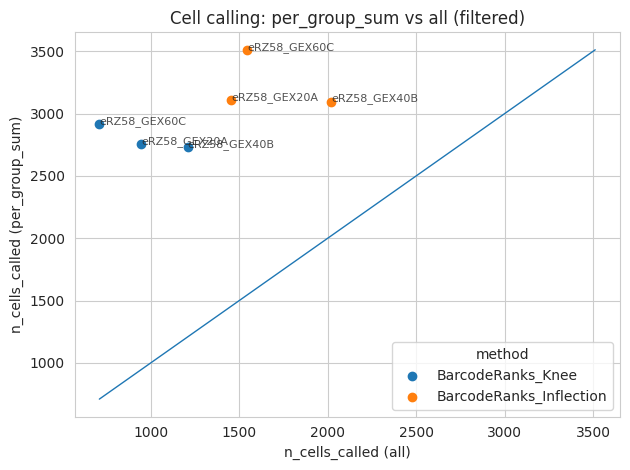

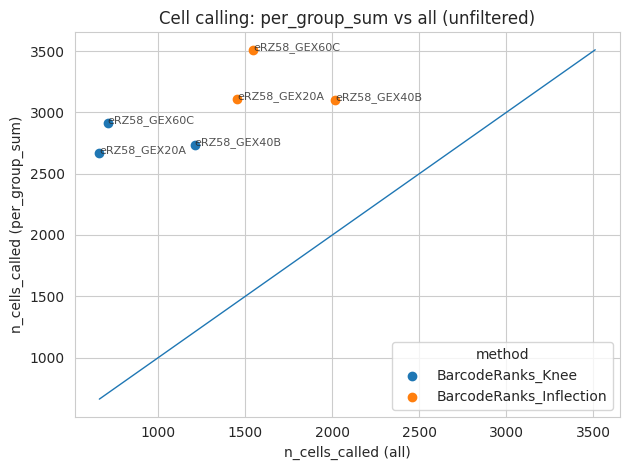

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = summary

methods = [ "BarcodeRanks_Knee", "BarcodeRanks_Inflection"]

def plot_one(filter_mode: str):
    d = df[df["filter_mode"] == filter_mode].copy()
    d = d[d["method"].isin(methods)]

    # 变成：每个 (sample_id, method, result_dir) 一行，包含 all 和 per_group_sum 两列
    wide = (d.pivot_table(index=["sample_id", "method", "result_dir"],
                          columns="calling_level",
                          values="n_cells_called",
                          aggfunc="first")
              .reset_index())

    # 只保留 all 和 per_group_sum 都存在的
    wide = wide.dropna(subset=["all", "per_group_sum"])

    # 画图
    fig, ax = plt.subplots()
    for m in methods:
        dd = wide[wide["method"] == m]
        if dd.empty:
            continue
        ax.scatter(dd["all"], dd["per_group_sum"], label=m)

        # 可选：给每个点标注 sample_id（如果点很多你可以注释掉这段）
        for _, r in dd.iterrows():
            ax.annotate(r["sample_id"].split(":")[-1], (r["all"], r["per_group_sum"]), fontsize=8, alpha=0.8)

    # y=x 参考线
    if not wide.empty:
        vmin = min(wide["all"].min(), wide["per_group_sum"].min())
        vmax = max(wide["all"].max(), wide["per_group_sum"].max())
        ax.plot([vmin, vmax], [vmin, vmax], linewidth=1)

    ax.set_title(f"Cell calling: per_group_sum vs all ({filter_mode})")
    ax.set_xlabel("n_cells_called (all)")
    ax.set_ylabel("n_cells_called (per_group_sum)")
    ax.legend(title="method", loc="lower right")
    plt.tight_layout()
    return fig, ax
    d = df[df["filter_mode"] == filter_mode].copy()
    d = d[d["method"].isin(methods)]

    wide = (d.pivot_table(index=["sample_id", "method", "result_dir"],
                          columns="calling_level",
                          values="n_cells_called",
                          aggfunc="first")
              .reset_index())

    wide = wide.dropna(subset=["all", "per_group_sum"])

    fig, ax = plt.subplots()
    for m in methods:
        dd = wide[wide["method"] == m]
        if dd.empty:
            continue
        ax.scatter(dd["all"], dd["per_group_sum"], label=m)

        # 可选：给每个点标注 sample_id（如果点很多你可以注释掉这段）
        for _, r in dd.iterrows():
            ax.annotate(r["sample_id"].split(":")[-1], (r["all"], r["per_group_sum"]), fontsize=8, alpha=0.8)

    if not wide.empty:
        vmin = min(wide["all"].min(), wide["per_group_sum"].min())
        vmax = max(wide["all"].max(), wide["per_group_sum"].max())
        ax.plot([vmin, vmax], [vmin, vmax], linewidth=1)

    ax.set_title(f"Cell calling: per_group_sum vs all ")
    ax.set_xlabel("n_cells_called (all)")
    ax.set_ylabel("n_cells_called (per_group_sum)")
    ax.legend(title="method", loc="lower right")
    plt.tight_layout()
    return fig, ax

# 画两张图
plot_one("filtered")
plot_one("unfiltered")
plt.show()

In [50]:
result_dirs = "dev_cell_calling_eRZ58:eRZ58_GEX60C_unfilered/"
adata_cell_calling = sc.read_h5ad(result_dirs + "eRZ58:eRZ58_GEX60C.cellcalling.h5ad")
adata_gRNA = sc.read_h5ad(result_dirs + "adata_unfiltered_annotated.h5ad")


mask_cc = adata_cell_calling.obs["is_cell_BarcodeRanks_Inflection_by_group"].astype(bool).values
adata_cc_sub = adata_cell_calling[mask_cc].copy()

ga = adata_gRNA.obsm["guide_assignment"]

if isinstance(ga, pd.DataFrame):
    mask_ga = ga.to_numpy().astype(bool).any(axis=1)
elif sp.issparse(ga):
    mask_ga = (np.array(ga.astype(bool).sum(axis=1)).ravel() > 0)
else:
    mask_ga = np.asarray(ga).astype(bool).any(axis=1)

adata_gRNA_assigned = adata_gRNA[mask_ga].copy()

bc_inter = adata_cc_sub.obs_names.intersection(adata_gRNA_assigned.obs_names)

adata_cc_inter = adata_cc_sub[bc_inter].copy()
adata_gRNA_inter = adata_gRNA_assigned[bc_inter].copy()

print("cell_calling (Inflection_by_group=True):", adata_cc_sub.n_obs)
print("gRNA (any guide assigned):", adata_gRNA_assigned.n_obs)
print("intersection:", len(bc_inter))

cell_calling (Inflection_by_group=True): 3511
gRNA (any guide assigned): 11126
intersection: 3428


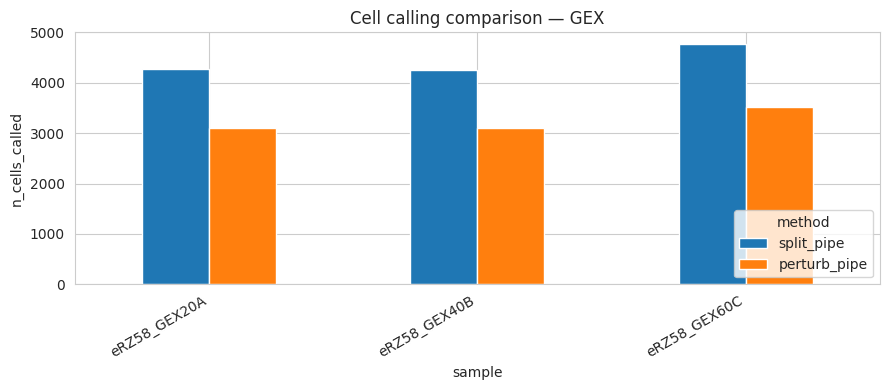

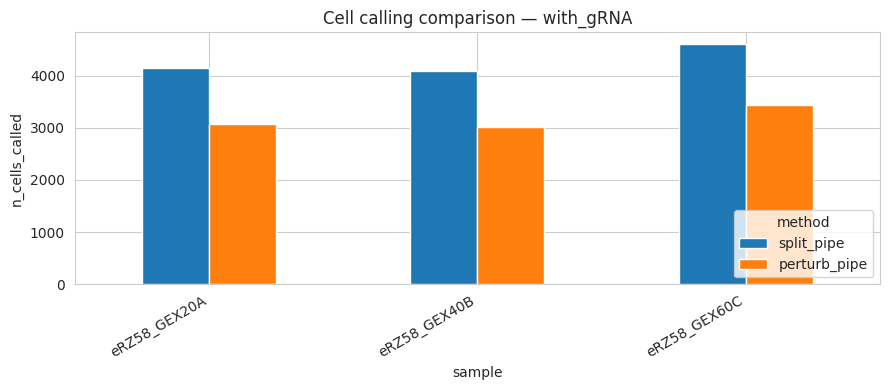

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

tsv_path = "cell_calling_methods_summary_w_split.tsv"  # 改成你的路径
df = pd.read_csv(tsv_path, sep="\t")

# 可选：把 sample label 简化（去掉 eRZ58: 前缀）
df["sample_short"] = df["sample_id"].str.replace(r"^.*:", "", regex=True)

method_order = ["split_pipe", "perturb_pipe"]

def barplot_by_type(df, cell_type, out_png):
    sub = df[df["type"] == cell_type].copy()

    piv = (sub.pivot(index="sample_short", columns="method", values="n_cells_called")
              .reindex(columns=method_order))

    ax = piv.plot(kind="bar", figsize=(9, 4))
    ax.set_title(f"Cell calling comparison — {cell_type}")
    ax.set_xlabel("sample")
    ax.set_ylabel("n_cells_called")
    ax.legend(title="method", loc="lower right")

    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    # plt.savefig(out_png, dpi=200)
    # plt.close()

barplot_by_type(df, "GEX", "cell_calling_bar_GEX.png")
barplot_by_type(df, "with_gRNA", "cell_calling_bar_with_gRNA.png")


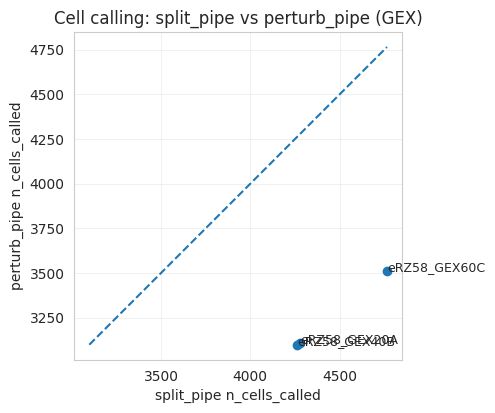

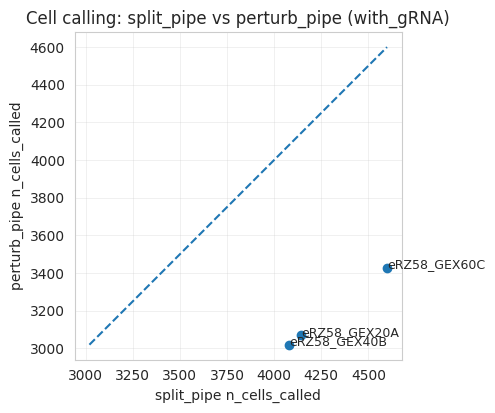

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

tsv_path = "cell_calling_methods_summary_w_split.tsv"  
df = pd.read_csv(tsv_path, sep="\t")

df["sample_short"] = df["sample_id"].str.replace(r"^.*:", "", regex=True)

def scatter_xy(df, cell_type, out_png):
    sub = df[df["type"] == cell_type].copy()

    # samples x methods
    piv = (sub.pivot(index="sample_short", columns="method", values="n_cells_called")
              .loc[:, ["split_pipe", "perturb_pipe"]]
              .dropna())

    x = piv["split_pipe"].astype(float).values
    y = piv["perturb_pipe"].astype(float).values

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y)

    # y=x 参考线
    mn = min(x.min(), y.min())
    mx = max(x.max(), y.max())
    ax.plot([mn, mx], [mn, mx], linestyle="--")

    # 标注 sample 名
    for s, xi, yi in zip(piv.index.tolist(), x, y):
        ax.text(xi, yi, s, fontsize=9)

    ax.set_xlabel("split_pipe n_cells_called")
    ax.set_ylabel("perturb_pipe n_cells_called")
    ax.set_title(f"Cell calling: split_pipe vs perturb_pipe ({cell_type})")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linewidth=0.5, alpha=0.4)

    plt.tight_layout()
    # plt.savefig(out_png, dpi=200)
    # plt.close(fig)

scatter_xy(df, "GEX", "cell_calling_scatter_GEX.png")
scatter_xy(df, "with_gRNA", "cell_calling_scatter_with_gRNA.png")

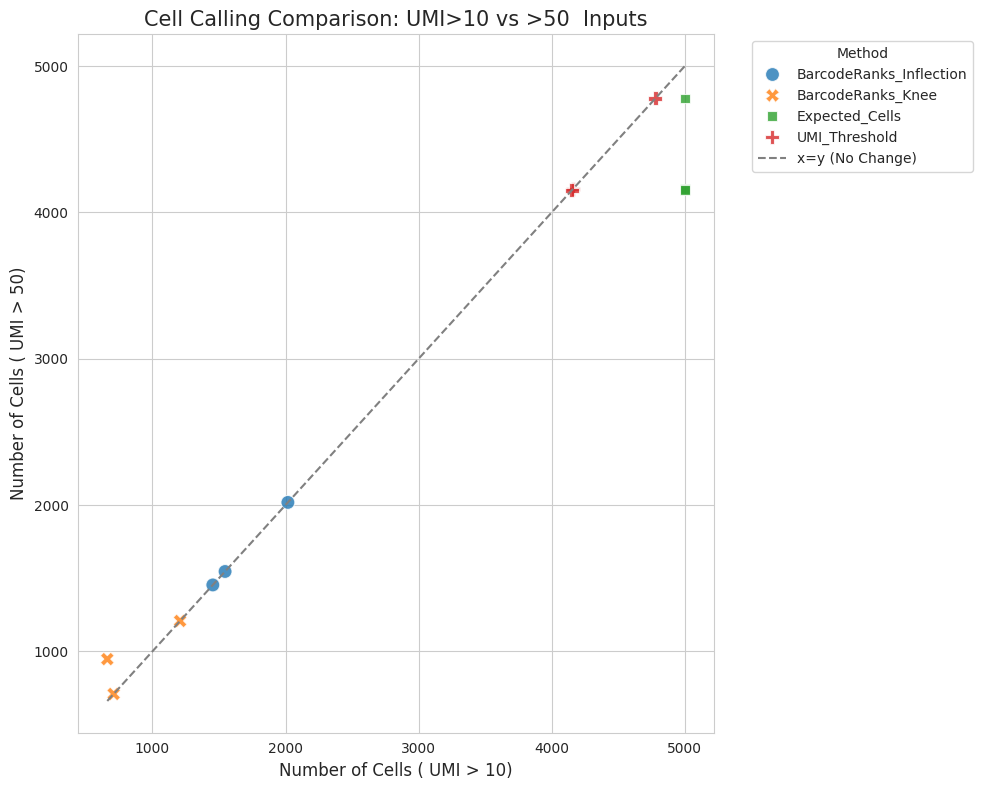

Data used for plotting (Head):
       base_sample_id                   method  n_cells_global_filtered  \
0  eRZ58:eRZ58_GEX20A  BarcodeRanks_Inflection                     1454   
1  eRZ58:eRZ58_GEX20A        BarcodeRanks_Knee                      947   
2  eRZ58:eRZ58_GEX20A           Expected_Cells                     4160   
3  eRZ58:eRZ58_GEX20A            UMI_Threshold                     4160   
4  eRZ58:eRZ58_GEX40B  BarcodeRanks_Inflection                     2018   

   n_cells_global_unfiltered  
0                       1454  
1                        661  
2                       5000  
3                       4160  
4                       2018  


In [10]:

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# 绘制散点
# x轴: Unfiltered, y轴: Filtered, hue: Method
scatter = sns.scatterplot(
    data=df_plot,
    x='n_cells_global_unfiltered',
    y='n_cells_global_filtered',
    hue='method',
    s=100,  # 点的大小
    alpha=0.8, # 透明度
    style='method' # 不同方法同时也使用不同形状，增强区分度
)

# 添加对角线 (x=y) 用于参考
# 如果点落在对角线上，说明 Filtered 和 Unfiltered 的细胞数一致
limit_min = min(df_plot['n_cells_global_unfiltered'].min(), df_plot['n_cells_global_filtered'].min())
limit_max = max(df_plot['n_cells_global_unfiltered'].max(), df_plot['n_cells_global_filtered'].max())
plt.plot([limit_min, limit_max], [limit_min, limit_max], color='gray', linestyle='--', label='x=y (No Change)')

# 设置标签和标题
plt.title('Cell Calling Comparison: UMI>10 vs >50  Inputs', fontsize=15)
plt.xlabel('Number of Cells ( UMI > 10)', fontsize=12)
plt.ylabel('Number of Cells ( UMI > 50)', fontsize=12)

# 优化图例
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Method')

plt.tight_layout()
plt.savefig("cell_calling_scatter_comparison.png", dpi=300)
plt.show()

# 打印数据检查一下匹配情况
print("Data used for plotting (Head):")
print(df_plot.head())